# Artigo 8 - Redes Convolucionais - Lion or Tiger

## Autor

Nome: Thiago Cerqueira Borges </br> 
Matricula: 190117508 </br>
Github: Thiago-Cerq </br>
---

| Hitórico de versão |    Data    |
|:------------------:|:----------:|
|      ver 1.0       | 20/12/2023 | 

---

## Introdução

Este projeto concentra-se na aplicação do aprendizado de máquina em redes convolucionais para o reconhecimento de imagens. Alinhado com os conceitos do Fastai sobre redes convolucionais, utiliza dados relevantes, como imagens de Leões e Tigres obtidas através da web ultilizando o DuckDuckGo. O fluxo de aquisição e pré-processamento dos dados é detalhado, e o projeto é organizado em células de código em um ambiente virtual do Kaggle, permitindo uma estrutura clara e interatividade na execução das etapas do projeto.

## Imports e função de busca

In [30]:
# Importando Bibliotecas necessarias
import numpy as np 
import pandas as pd
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *


def search_images(term, max_images=400): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


## Objetivo

Este projeto tem como objetivo empregar redes neurais convolucionais (CNN) para distinguir entre imagens de tigres e leões. A abordagem envolve a construção e treinamento de um modelo utilizando dados rotulados desses felinos, permitindo que a CNN aprenda características distintivas. O processo inclui aquisição, pré-processamento e análise das imagens, visando criar um modelo eficiente para o reconhecimento automático de tigres e leões.

## Analisando Imagens 

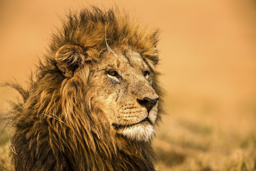

In [32]:
urls = search_images('Lion photos', max_images=1)

from fastdownload import download_url
dest = 'Lion.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

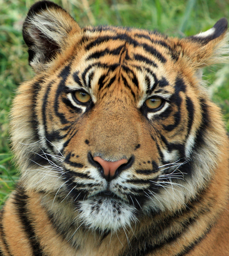

In [33]:
urls = search_images('Tiger photos', max_images=1)

from fastdownload import download_url
dest = 'Tiger.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

No processo acima, realizamos o download de imagens de um Leões e Tigres utilizando, seguido pela exibição em miniatura para verificar a funcionalidade correta. 

## Agora baixaos em grande escala

Nesta etrapa, as imagens são baixadas e organizadas em um bloco de dados "DataBlock", especificando os blocos de entrada e saída, juntamente com transformações de dados e a divisão em conjuntos de treinamento e validação.Tambem, é apresentado um lote de imagens dos conjuntos de dados de treinamento e validação usando a função show_batch, proporcionando uma compreensão visual da organização dos dados.

In [34]:
searches = 'Lion', 'Tiger'
path = Path('Felinos')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    download_images(dest, urls=search_images(f'{o} pictures'))
    sleep(1)  
    resize_images(path/o, max_size=400, dest=path/o)

### Removendo imagens com falhas

In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


8

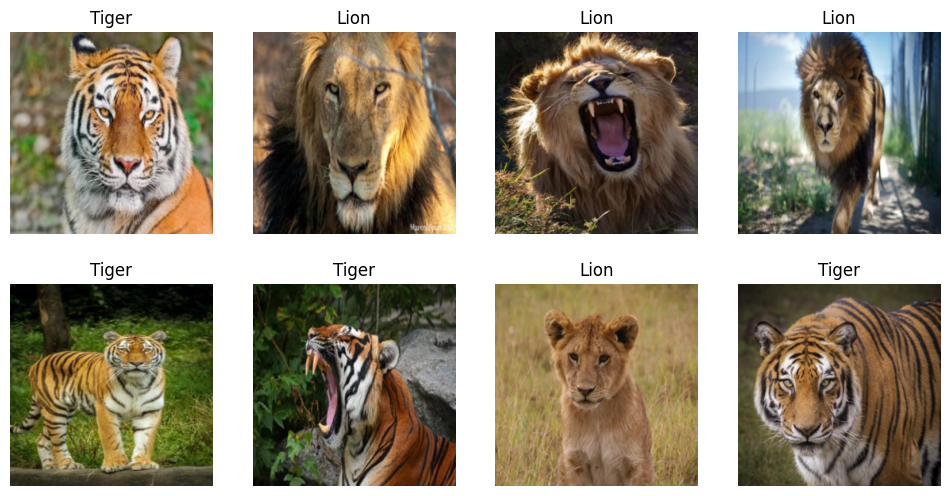

In [36]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

## CNN - Convolutional Neural Network

Agora vamos pegar uma imagem do dataset com a qual vamos trabalhar.Essa imagem então foi transformada num array de 64 por 64 por 3, sendo 64 por 64 sua resolução e o 3 para compor os 3 canais de RGB (Red,Green and Blue), formando as cores.
Faremos para as duas imagens.

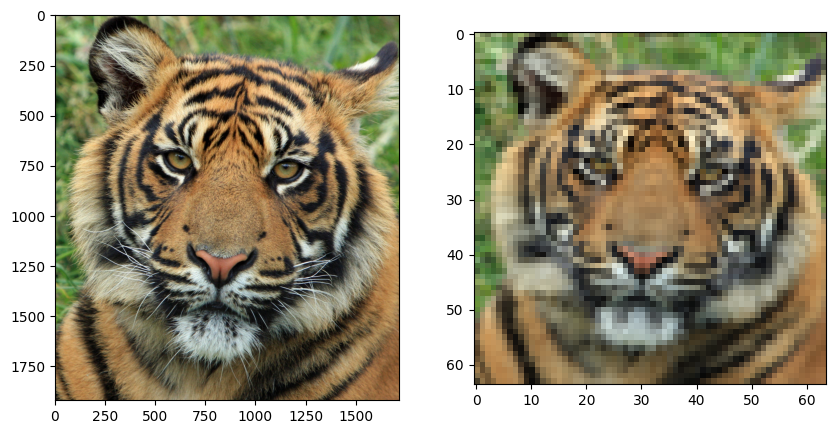

In [38]:
im = Image.open(r'/kaggle/working/Tiger.jpg')
newsize = (64, 64)
im2 = im.resize(newsize)
from matplotlib import pyplot as plt
img = np.asarray(im2)

original = np.asarray(im, dtype=np.uint8)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(original)
axs[1].imshow(img)

In [39]:
plot = {}
for y in range(3):
    for x in range(3):
        value_x = 15+x
        value_y = 15+y
        plot[f'{value_x}:{value_y}'] = img[value_x][value_y]

plot

{'15:15': array([198, 165, 109], dtype=uint8),
 '16:15': array([182, 141,  86], dtype=uint8),
 '17:15': array([168, 124,  72], dtype=uint8),
 '15:16': array([186, 136,  76], dtype=uint8),
 '16:16': array([157, 108,  58], dtype=uint8),
 '17:16': array([185, 146,  96], dtype=uint8),
 '15:17': array([155, 101,  51], dtype=uint8),
 '16:17': array([161, 118,  71], dtype=uint8),
 '17:17': array([113,  96,  75], dtype=uint8)}

In [41]:
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[0][0][0] = 0.8
filter_1[0][0][1] = 0.2
filter_1[0][0][2] = 0.8

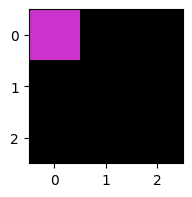

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(filter_1)

Então temos uma matriz 3x3 com um valor diferente de zero no meio (destacado em cores), sendo as áreas pretas equivalentes a zero. Essa matriz é um filtro usado em convoluções para modificar imagens.

In [78]:
img_2 = np.zeros((64,64,3), dtype=float)

for i in range(50):
    for j in range(50):
        img_2[i][j][0] = img[:,:,0][i][j] * 0.8
        img_2[i][j][1] = img[:,:,1][i][j] * 0.2
        img_2[i][j][2] = img[:,:,2][i][j] * 0.8

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(64, 64, 3)

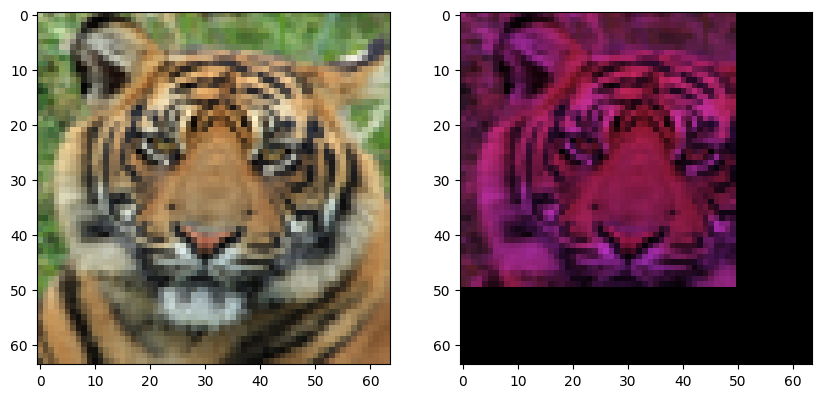

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(img_2)

In [ ]:
A imagem resultante da convolução da tigre original (imagem à esquerda) com esse filtro é mostrada à direita.

## Dropout

O Dropout é uma técnica de regularização frequentemente aplicada em redes neurais convolucionais para prevenir o overfitting. Durante o treinamento, uma fração aleatória de neurônios é temporariamente desativada, promovendo a aprendizagem de características mais robustas e reduzindo a dependência excessiva de padrões específicos nos dados de treinamento. Essa abordagem contribui para melhorar a generalização do modelo e sua capacidade de lidar com dados novos.

In [46]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [47]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

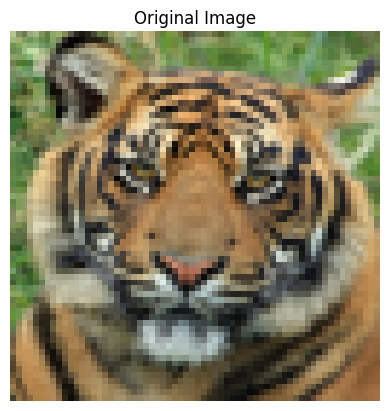

In [48]:
show_img(img, title="Original Image")

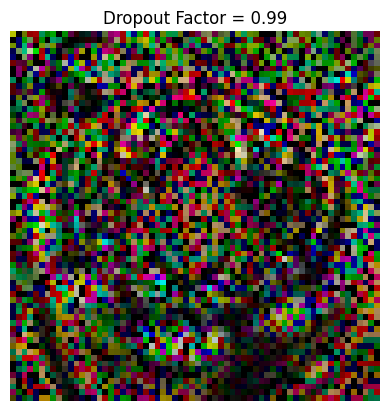

In [82]:
dropped_img = dropout_np(img)
show_img(dropped_img, title="Dropout Factor = 0.99")

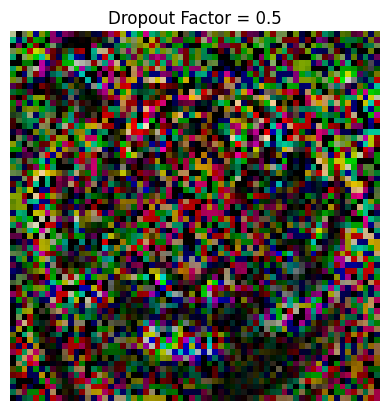

In [49]:
dropped_img = dropout_np(img)
show_img(dropped_img, title="Dropout Factor = 0.5")

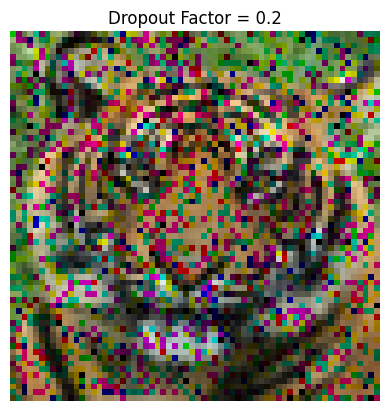

In [50]:
dropped_img = dropout_np(img, 0.2)
show_img(dropped_img, title="Dropout Factor = 0.2")

## Detecção de Bordas

A detecção de bordas em processamento de imagem, especialmente em convolução, envolve a aplicação de filtros que realçam as transições de intensidade, destacando as bordas nas imagens. Um método comum é a aplicação de operadores de convolução, como o operador de Sobel, que calcula as derivadas parciais em diferentes direções. Esses filtros enfatizam mudanças abruptas de intensidade, identificando assim as bordas. A detecção de bordas é crucial em diversas aplicações, como reconhecimento de objetos e segmentação de imagens, proporcionando informações importantes sobre a estrutura e os contornos das formas na imagem.

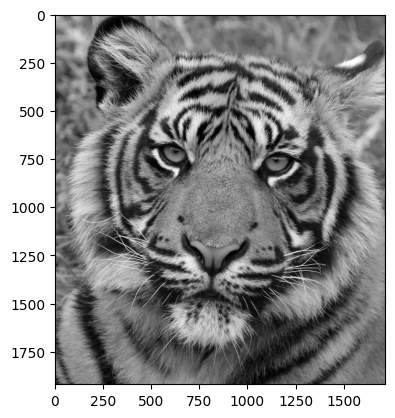

In [51]:
img_bw = im.convert(mode='L')
img_bw = np.asarray(img_bw, dtype=np.uint8)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)

In [52]:
np.shape(img_bw)

(1920, 1717)

In [53]:
from scipy import signal as sig

In [54]:
#Bordas horizontais
filter_2 = [-0.125, 0.0, 0.125],[-0.25, 0.0, 0.25],[-0.125, 0.0, 0.125]
filter_2 = np.asarray(filter_2)

In [55]:
#Bordas verticais
filter_3 = [-0.125, -0.25, -0.125],[0.0, 0.0, 0.0],[0.125, 0.25, 0.125]
filter_3 = np.asarray(filter_3)

## Convolução com os filtros

In [57]:
img_4 = sig.fftconvolve(img_bw, filter_2, mode = 'same')
img_4 = np.asarray(img_4, dtype=np.uint8) / 1.25

In [59]:
img_5 = sig.fftconvolve(img_bw, filter_3, mode = 'same')
img_5 = np.asarray(img_5, dtype=np.uint8) / 1.25

sobel = np.sqrt(np.square(img_4) + np.square(img_5)) / 1.25

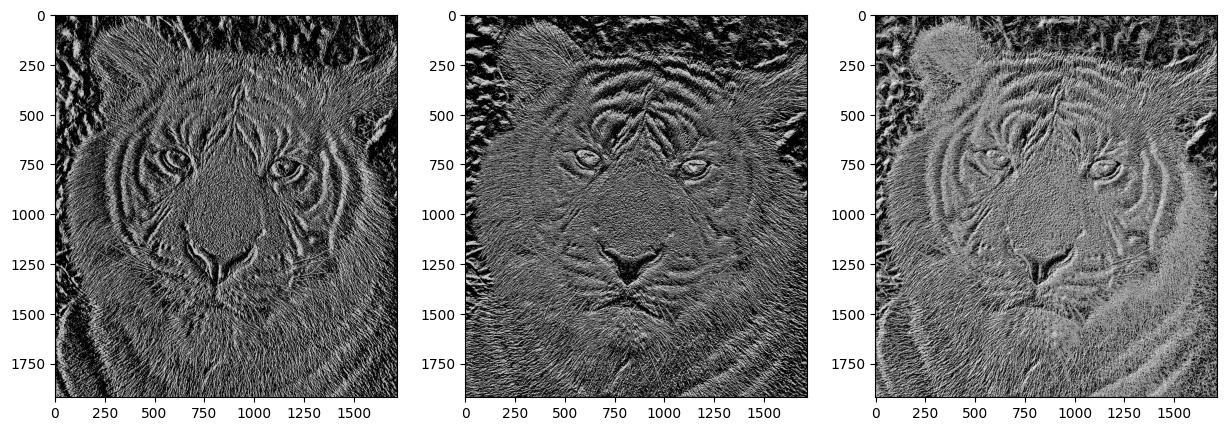

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img_4, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(img_5, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(sobel, cmap='gray', vmin=0, vmax=255)

## Modelos

### Resnet 50

In [61]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 


epoch,train_loss,valid_loss,time
0,0.365309,0.006154,00:15


epoch,train_loss,valid_loss,time
0,0.008327,0.000845,00:09
1,0.010429,0.001119,00:07
2,0.007479,0.001956,00:08
3,0.005179,0.000040,00:08
4,0.009215,0.032398,00:08
5,0.017761,0.002091,00:08
6,0.013417,0.001104,00:08
7,0.036731,0.000126,00:08
8,0.026274,0.000019,00:07
9,0.019018,0.000030,00:07


### Modelo Manual

In [62]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [63]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,64),
    conv(64,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [64]:
learn2 = Learner(dls, simple_cnn)

In [66]:
learn2.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.692999,1.269063,00:02


epoch,train_loss,valid_loss,time
0,1.578149,1.188360,00:02
1,1.577428,1.158709,00:02
2,1.592712,1.107551,00:02
3,1.559521,1.080775,00:02
4,1.530574,1.071658,00:02
5,1.517421,1.057492,00:02
6,1.495365,1.043099,00:02
7,1.489169,1.027960,00:02
8,1.492530,1.028722,00:02
9,1.508525,1.025295,00:02


In [83]:
learn.export('resnet.pkl')
learn2.export('made.pkl')

## Link para acessar a aplicação no p Hugging Face 🤗
​
Resnet 50: https://huggingface.co/spaces/Thiago-Cerq/Tigre_or_Lion_Resnet
​

Modelo Manual: https://huggingface.co/spaces/Thiago-Cerq/Lior_or_Tiger_Manual
​
# Referências
​
Jeremy Howard and Sylvain Gugge. FastBook. Disponível em https://github.com/fastai/fastbook. Acessado e 20 de Dezembro de 2023.
​

Repositorio da Disciplina Disponível em https://github.com/fabraz/fastaiOnCampus. Acessado e 20 de Dezembro de 2023.